# Root Inc. data exercise 

### Hanwen Lu

In [7]:
# Import necesarry packages for DA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

# Import packages for modeling
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier


from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import shap
%matplotlib inline

## EDA 

In the EDA, I will take the following steps:
1. First read the model_train data for some summary statistics, both on features and the labels
2. Import few of the trip data for EDA and feature extraction
3. Batch process trip data, combine with model_train data for final feature selections and EDA

### Import model_train data and explore

In [8]:
df_train = pd.read_csv('./work_sample/model_data_train.csv')

In [9]:
df_train.head()

,filename,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,y
0,0000.csv,False,False,True,5.209096,9789.261511,30753.872048,0.001010,5,13,1,9.373984e+03,0.317920,9.379193e+03,4.974085,0
1,0001.csv,False,False,False,4.450941,10552.521899,33151.725274,0.001000,3,11,1,4.251619e+04,2.229321,4.252064e+04,3.151531,0
2,0002.csv,False,False,True,5.396552,10233.433119,32149.278307,0.001015,6,13,1,1.305321e+07,34.259512,1.305322e+07,6.236594,0
3,0003.csv,False,False,True,4.970163,10829.056746,34020.485118,0.000993,4,8,1,1.131908e+03,25.768714,1.136878e+03,3.968008,1
4,0004.csv,False,False,False,5.266868,10678.703687,33548.137053,0.001009,6,11,1,3.163256e+03,145.154357,3.168523e+03,5.999782,0


Some observations:

1. I note that this is a dataset with binary label
2. Feature 1-3 are boolean features 
3. others are numeric
4. No missing values

Next, we should look at some statistics about the numerics and the boolean features

In [10]:
df_train.describe()

,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,4.984873,9977.840571,31346.310636,0.001000,4.974000,10.053000,1.0,8.861258e+08,8.845462e+03,8.861258e+08,4.976221,0.310000
std,0.997816,990.773528,3112.606836,0.000010,1.556839,3.015507,0.0,1.957633e+10,8.087624e+04,1.957633e+10,1.560448,0.462725
min,2.116270,7193.513346,22599.088680,0.000971,1.000000,2.000000,1.0,8.550778e-03,4.504803e-08,4.320016e+00,0.825435,0.000000
25%,4.324381,9314.992298,29263.911371,0.000993,4.000000,8.000000,1.0,7.959224e+02,1.320425e-01,8.009469e+02,3.980613,0.000000
50%,4.990547,9961.242569,31294.166476,0.001001,5.000000,10.000000,1.0,2.294823e+04,2.744109e+00,2.295354e+04,4.988078,0.000000
75%,5.675052,10678.569893,33547.716728,0.001007,6.000000,12.000000,1.0,6.395295e+05,7.829274e+01,6.395340e+05,6.022663,1.000000
max,8.819192,12819.907634,40274.927643,0.001035,10.000000,22.000000,1.0,6.069658e+11,1.572134e+06,6.069658e+11,10.327562,1.000000


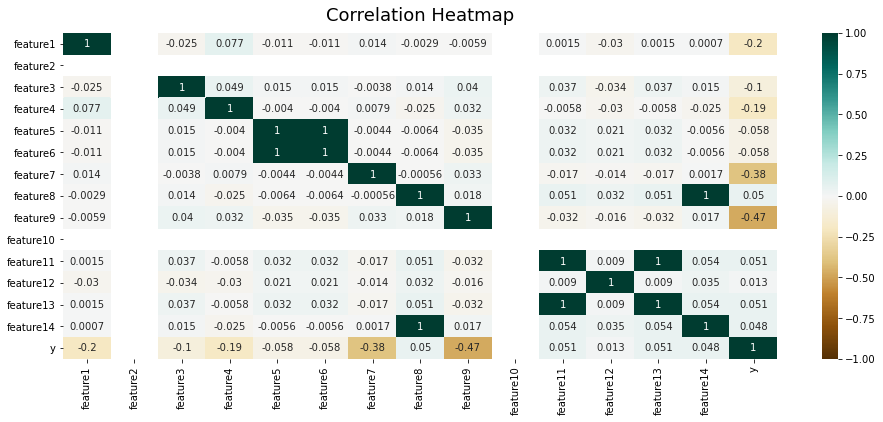

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [12]:
(df_train['feature12']>1*10**6).sum()

2

Some observations for the numerical variables:
1. the scales of the numeric features are very different:
    - feature4 ~ 10^0
    - feature5 ~ 10^3
    - feature6 ~ 10^4
    - feature12 ~ 10^1
    - feature11&13 ~ 10^4
2. features 11 - 13 seems to be quite skewed with large variance, or with outliers.
3. feature5 and 6, feature 8 and 14, and feature 11 and 13 are highly correlated 
4. feature 12 appears to have outliers (may need to check for outliers and data cleaning) 
5. feature 5 may require standardization, we will deal with it later with pipeline to prevent data leakage for validation
6. feature 10 is useless containing only value of 1



In [13]:
# Check the count of boolean features in each labels
for i in range(1, 4):
    print("The feature distribution for ", df_train.columns[i], " is:")
    print(df_train.iloc[:,i].value_counts())

The feature distribution for  feature1  is:
False    898
True     102
Name: feature1, dtype: int64
The feature distribution for  feature2  is:
False    1000
Name: feature2, dtype: int64
The feature distribution for  feature3  is:
True     507
False    493
Name: feature3, dtype: int64


Some observations for the boolean features and label:
1. feature1 is unbalanced 
2. feature2 does not seem to be useful
3. feature3 is unbalanced 
4. labels seemed to be unbalance (need to be conscious when choosing metrics for eval model) 

### Summary on Model_data 

From the EDA above, I can see that data cleaning is necessary prior to modeling.

For numerical features, I found:
1. There are several features pairs showed perfect correlation. Dropping some of these correlated feature may help to arrive at the correct model intepretations/feature importance for some models. 
2. The numeric features appeared to be on different scales, feature transformation may be useful for modeling.
3. Some features appeared to have outliers, removing or capping outliers may be useful. 
4. Some features do not provide any information

For categorical features, I found:
1. The distribution of the labels is unbalanced, choosing model evaluation metrics should take this into account
2. Some features do not provide any information 

In the following section, I will define a function **"preprocess_model"** to implement these data cleaning process (this function is included in the same cell as other feature extraction functions for convineince)

### Import trip_data and explore

From the trip data, I will extract two features:

- Number of turns
- Number of stops 

I will now explore the 0001.csv trip data for feature engineering

In [15]:
# Load trip data
path = "./work_sample/trip_data_train/trip_data/"
name = "0001"+".csv"
df_trip = pd.read_csv(path+name)

In [16]:
# Take a look at the trip data
df_trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time_seconds             631 non-null    float64
 1   speed_meters_per_second  631 non-null    float64
 2   heading_degrees          625 non-null    float64
dtypes: float64(3)
memory usage: 14.9 KB


In [17]:
df_trip.head(10)

,time_seconds,speed_meters_per_second,heading_degrees
0,0.000,9.170000,NaN
1,0.994,9.311178,NaN
2,1.711,11.184463,NaN
3,2.711,11.820962,89.572280
4,3.711,12.141592,89.334795
5,4.711,13.059472,89.097310
6,5.711,13.577563,88.833265
7,6.711,13.978872,88.674838
8,7.711,13.911827,88.370400
9,8.711,13.718717,88.160956


In [18]:
# First, investigate the sampling rate of the data acquisition
df_trip.time_seconds.diff().value_counts()

1.000    611
0.717      1
1.000      1
2.000      1
1.000      1
0.994      1
1.000      1
1.000      1
1.000      1
0.253      1
0.499      1
1.000      1
1.000      1
1.612      1
0.848      1
0.232      1
0.152      1
0.388      1
0.248      1
0.768      1
Name: time_seconds, dtype: int64

Although most data were colleted at 1 sec interval, I will resample the dataset to 1 second interval with forward linear intepolation

In [19]:
# We can see that data are recorded per second basis with some fluctuation, try resample to convert time to consist unit
df_trip.time_seconds = pd.to_timedelta(df_trip.time_seconds, unit="s")
df_trip.set_index(df_trip.time_seconds, inplace=True)
df_trip.resample("1s").interpolate(method='linear', limit_direction='forward', axis=0)
df_trip.drop(columns = ["time_seconds"], inplace = True)


Plot speed as function of elapsed time 

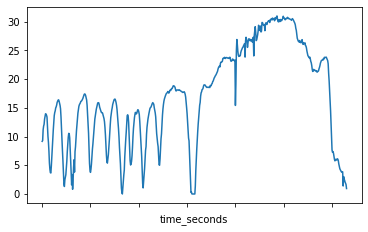

In [195]:
df_trip.iloc[:,0].plot()

Plot heading degree as a function of elasped time

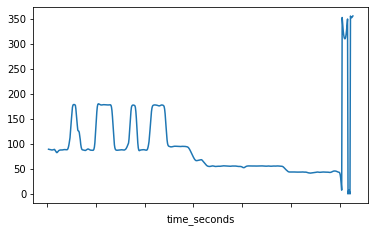

In [196]:
df_trip.iloc[:,1].plot()

Plot the rate of change of heading degree as function of time

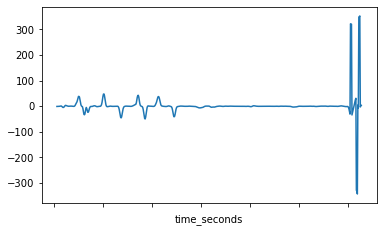

In [23]:
df_trip.iloc[:,1].diff(3).plot()

#### Some observations on the trip data:

1. Data acquistion rate is 1 second, but with some exceptions
2. Some missing values
3. both trip speed and heading degree has fluctuation, from this I will define and extract the stop count and turn count features
4. Discontinuity in heading degree, presumably due to the discontinuous reading at 360 degree. 


#### Definitino of stops and turns 

Given the that we know from this trip_data, there is approximate 1 stop and 9 turns, I will define turn and stop as follow:

* **Stop: a stop is an interval with consecutive speed reading that is below 0.1 m/s for over 3 seconds.** 

* **Turn: a turn is a change in heading degree over 60 degree within 3 seconds.**

In the section below, I will implement two functions that will return the stop count and turn count following these rules:

* A **stopCount** function that traverse through the list of speed record, and find the number of intervals within the list that consist of a speed below 0.1 m/s for over 3 seconds

* A **turnCount** function that calculate the rate of change in heading degree (by differencing at time interval of 3 second), and find the number of peaks that the rate of change is greater than 60 degree. 

## Implementation of data cleaning and feature extraction functions

In [87]:
# Define function to preprocess model_train dataset based on EDA
def preprocess_model(df):
    
    #Drop correlated features
    df.drop(columns = ["feature2", "feature6", "feature8", "feature10", "feature13"], inplace=True)
    
    #Log transform features with large variability
    df["feature11"] = np.log10(df["feature11"])
    
    #Capping the outlier with Percentiles for feature 12
    upper_lim = df['feature12'].quantile(.95)
    lower_lim = df['feature12'].quantile(.05)
    df.loc[(df['feature12'] > upper_lim),'feature12'] = upper_lim
    df.loc[(df['feature12'] < lower_lim),'feature12'] = lower_lim
    
    # Numeric encoding for binary categorical variables
    df['feature1'] = df['feature1'].apply(lambda x: int(x))
    df['feature3'] = df['feature3'].apply(lambda x: int(x))


#-----------------------------------------------------------------------------------------------------------#
# Define functions for feature extractions on trip_data

# define function for resampling data aquisition rate 
def preProcess(df_trip):
    '''
    Input:
    df_trip: dataframe containing trip data
    
    Output:
    df_trip: dataframe resampled based on delta time with missing values filled in
    '''
    # resample df based on time recorded 
    df_trip.time_seconds = pd.to_timedelta(df_trip.time_seconds, unit="s")
    df_trip.set_index(df_trip.time_seconds, inplace=True)
    df_trip.drop(columns = ["time_seconds"], inplace = True)
    df_trip.resample("1s").interpolate(method='linear', limit_direction='forward', axis=0)    
    
    return df_trip


# Define function for counting number of stops in a trip 
def countStop(df_trip, min_speed, stop_duration=3):
    '''
    Input:
    df_trip: dataframe containing trip data
    min_speed: a minimum float value below which is considered as coming to a stop
    stop_duration: An integer of the duration (sec) over which speed is zero should be considered as a stop
                   Default = 3. 
    
    Output:
    stop_count: An integer count of number of stops in the speed list
    '''
    speed = df_trip['speed_meters_per_second']
    stop_count = 0 
    isStop = False
    i=1 
    while i<len(speed):
        # counter for consecutive zeros
        cnt=0 
        
        # start counter for consective zeros if first encountered zero
        if speed[i] <= min_speed and speed[i-1]>min_speed:
            cnt +=1
            i+=1
        
        # keep traversing the list until consecutive zeros are terminated
            while i<len(speed) and speed[i]<= min_speed:
                cnt +=1
                
                # Identify a stop by definition
                if cnt>=stop_duration:
                    isStop = True
                i+=1
        
            # backtrack one step to first non zero index after terminating the inner loop
            i-=1
            
            # increment stop_count
            stop_count+=isStop
            
            # reset the stop boolean 
            isStop = False

        i +=1
        
    return stop_count
            

def countTurn(df_trip, turn, turn_duration=3):
    '''
    Input:
    
    speed: A list of float that recordes the speed
    
    turn: Ingeter represents the lower bound of the change of agnle for a turn on the turn duration
               
    turn_duration: An integer of the duration (sec) of a turn. Default = 3 sec
                   
    
    Output:
    turn_count: An integer count of number of turns in the speed list
    '''
    
    # Handle the discontinuity at 360 degree (a full turn of heading_degrees) if a turn occurs near 360 heading degree
    func = lambda x: 360-x if x>360-(turn) else (360+x if x<(turn)-360 else x)
    heading_change=df_trip['heading_degrees'].diff(turn_duration).apply(func)

    # Find the count of instances where the change of heading degree is greater than a turn (over 60 degree in 3 seconds)
    # I multiply the peak height by 1.5 to match the expected result for turn counts 
    turn_count,_ = find_peaks(abs(heading_change), height = turn/turn_duration*1.5) 
    
    return len(turn_count), heading_change


def extractFeature(path, filename):
    '''
    Input:
    
    Path: path of the trip data from which we generate the addtional features
    filename: the filename of the trip data
                   
    
    Output:
    turn_count: A list containing the filname, and the two augemented features: the count of stop and the cout of turn 
    '''
    df_trip = pd.read_csv(path+filename)
    df_trip = preProcess(df_trip)
    turn_count,_ = countTurn(df_trip, 60)
    return [filename, countStop(df_trip, 0.1), turn_count]



#--------------------------------------------------------------------------------------------------#
# Augment features and merge training set 

def augment_df(path, df):
    '''
    Input:
    
    Path: path of the trip data files from which we generate the addtional features
    df: the dataframe that will be augmented with the extracted features
                   
    Output:
    
    df: the augmented dataframe with stop_count and turn_count features
    '''
    extracted_feat = []
    
    # Loop through all trip files to extract features
    for filename in df.filename:
        extracted_feat.append(extractFeature(path, filename))
    
    # merge extracted features with model_data 
    features = pd.DataFrame(extracted_feat)
    df = df.merge(pd.DataFrame(extracted_feat), left_on='filename', right_on=0)
    filename = df['filename']
    df.drop(columns = ['filename', 0], inplace = True)
    df.rename(columns = {1:"stop_count", 2:"turn_count"}, inplace = True)
    
    return df, filename

# wrapper function that return augemented dataframe
def getData(model_path, trip_path):
    '''
    Input:
    
    model_path: file path from which model data is read
    trip_path: file path from which trip data is read
    
    Output:
    
    df: The augmented dataframe for building model 
                   
    '''
    df = pd.read_csv(model_path)
    preprocess_model(df)
    df, filename = augment_df(trip_path, df)
    return df, filename

A sample output of the stopTurn function

In [189]:
print('The number of stops in trip_data 0001.csv is:  %d' %countStop(df_trip, 0.1))

The number of stops in trip_data 0001.csv is:  1


A sample output of the countTurn function

In [190]:
turn_count, heading = countTurn(df_trip, 60, 3)
print('The number of turns in trip_data 0001.csv is:  %d' %turn_count)

The number of turns in trip_data 0001.csv is:  10


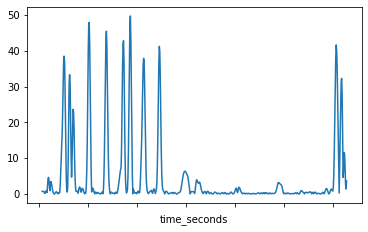

In [90]:
# vsualize the heading degree change from countTurn function that handled the discontinuity at 360 
abs(heading).plot()

### Get preprocessed/augmented data

In [91]:
model_path = "./work_sample/model_data_train.csv"
trip_path = "./work_sample/trip_data_train/trip_data/"
df_train,_ = getData(model_path, trip_path)

In [92]:
df_train.head()

,feature1,feature3,feature4,feature5,feature7,feature9,feature11,feature12,feature14,y,stop_count,turn_count
0,0,1,5.209096,9789.261511,0.001010,13,3.971924,0.317920,4.974085,0,0,3
1,0,0,4.450941,10552.521899,0.001000,11,4.628554,2.229321,3.151531,0,1,10
2,0,1,5.396552,10233.433119,0.001015,13,7.115717,34.259512,6.236594,0,0,5
3,0,1,4.970163,10829.056746,0.000993,8,3.053811,25.768714,3.968008,1,2,7
4,0,0,5.266868,10678.703687,0.001009,11,3.500134,145.154357,5.999782,0,15,2


In [98]:
# switch dataframe columns
columns = df_train.columns.values
columns = list(columns[:-3])+list(columns[-2:]) + list(columns[-3])
df_train = df_train.reindex(columns = columns)

In [184]:
df_train.head()

,feature1,feature3,feature4,feature5,feature7,feature9,feature11,feature12,feature14,stop_count,turn_count,y
0,0,1,5.209096,9789.261511,0.001010,13,3.971924,0.317920,4.974085,0,3,0
1,0,0,4.450941,10552.521899,0.001000,11,4.628554,2.229321,3.151531,1,10,0
2,0,1,5.396552,10233.433119,0.001015,13,7.115717,34.259512,6.236594,0,5,0
3,0,1,4.970163,10829.056746,0.000993,8,3.053811,25.768714,3.968008,2,7,1
4,0,0,5.266868,10678.703687,0.001009,11,3.500134,145.154357,5.999782,15,2,0


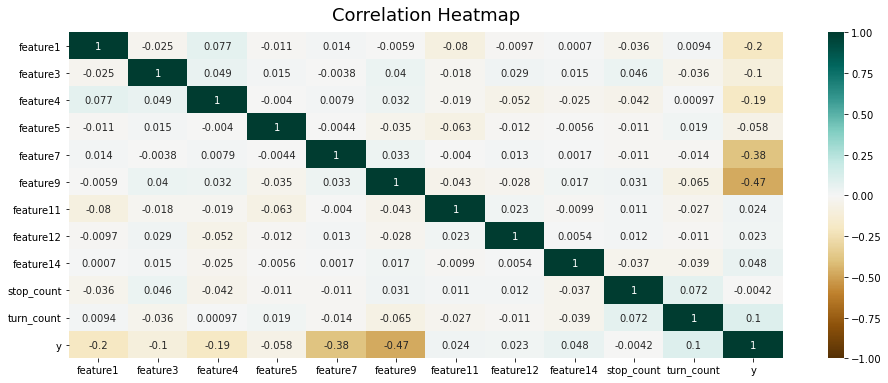

In [99]:
# Plot the correlation matrix of the final dataframe
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Here I observed that the label does not have strong correlations with many of the features, including the augmented features. it is likely that a linear model will have subpar performance.

Therefore, in the modeling section, I will start with a couple of ensemble tree models (as opposed to linear model such as Logistic Regression etc.) to build the classifier for better explaning power. 

## Modeling

In [170]:
# split label and training set
df_y = df_train['y']
df_X = df_train.drop(columns =['y']) 


In [171]:
# split hold out set for accessing model performance
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=random_state, stratify=df_y)

### Build model pipeline

Here, the pipeline inlcudes the following steps:
 - Preprocessing.
 - Model selection, evaluation and validation.
 - Model parameters tuning.
 - Model intepretation. 
 
Some remarks about these steps:
 - Preprocessing: Most preprocessing are done in previous sections, optiionally, we can standardize large numeric features using pipeline object in sklearn to prvent data leakage. 
 - Model selection: I chose to use boosted tree for good model explaining power (as mentioned before, linear model may not be sufficient) and inteprebility. 
 - Model evaluation and validation: Due to the imbalance, I choose to evaluate the model with F1-score, other reasonable scoring rules can be precision, recall, ROC-AUC or other scoring rules, depending on the business context. I will conduct k-fold cross validation with stratification. 
 - Model hyperparameters tuning: I will conduct randomized grid search for optimal set of hyperparameters
 - Model intepretation: I will look at the permutation importance/Shapley value of the features.  

In [172]:

# Note that earlier, feature5 requires standardization
# feature_to_be_scaled = ['feature5']
# feature_transformer = Pipeline([('scaler', StandardScaler())])
# preprocessor = ColumnTransformer(transformers = [('num', feature_transformer, feature_to_be_scaled)])

score = 'f1'
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)
clf = Pipeline(steps=[('classifier', XGBClassifier())])

# clf = Pipeline(steps=[('classifier', RandomForestClassifier())])


param = {    
    'classifier__verbosity':[0],
    'classifier__use_label_encoder':[False], 
    'classifier__colsample_bytree':[0.7, 0.8, 0.9],
    'classifier__subsample':[0.7,0.8,0.9],
    'classifier__n_estimators':[20, 40, 50, 60, 80, 100],
    'classifier__gamma':[0.1, 0.01, 0.02], #0.05, 0.1, 0.4
    'classifier__min_child_weight':[2,4,6,8], # 1, 2, 5
    'classifier__learning_rate':[0.1,0.15,0.2],
    'classifier__max_depth':[4, 5, 6, 7],
    'classifier__reg_alpha':[0.01, 0.1, 0.2], #0.1, 0.3, 0.5
    'classifier__scale_pos_weight': [1,2],
    'classifier__n_jobs':[4]
}



# param = {
#      'classifier__bootstrap': [True, False],
#      'classifier__max_depth': [35, 40, 45],
#      'classifier__max_features': ['auto', 'sqrt'],
#      'classifier__min_samples_leaf': [2, 4, 8],
#      'classifier__min_samples_split': [5, 10, 15, 20],
#      'classifier__n_estimators': [200, 300, 400, 500, 600],
#      'classifier__n_jobs':[4]
# }

rgsearch = RandomizedSearchCV(clf, param_distributions = param, cv=skf, verbose=0, scoring=score, random_state=random_state)
rgsearch.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_rate=None,
                                                          

### Model Validation

In [173]:
print(rgsearch.best_params_)    
print(rgsearch.best_score_)   

{'classifier__verbosity': 0, 'classifier__use_label_encoder': False, 'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 2, 'classifier__reg_alpha': 0.2, 'classifier__n_jobs': 4, 'classifier__n_estimators': 40, 'classifier__min_child_weight': 4, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.01, 'classifier__colsample_bytree': 0.9}
0.7607837186482187


In [174]:
# Calculate the confusion matrix of the training set and compare to validation score 
CM = confusion_matrix(y_test, rgsearch.predict(X_test))
print(CM)

[[126  12]
 [ 10  52]]


In [182]:
# Calulate recall/precision and f1 from confusion matrix
acc = (CM[1][1]+CM[0][0])/CM.sum().sum()
prec = CM[1][1]/(CM[1][1]+CM[0][1])
recall = CM[1][1]/(CM[1].sum())
print('The accuracy of the classifier is %.3f' %acc)
print('The precision of the classifier is %.3f' %prec)
print('The recall of the classifier is %.3f' %recall)
print('The f1 of the classifier is %.3f' %(2*prec*recall/(prec+recall)))

The accuracy of the classifier is 0.890
The precision of the classifier is 0.812
The recall of the classifier is 0.839
The f1 of the classifier is 0.825


Summary on the model building, tuning and evaluation:
1. I chose to build a classifier with ensemble trees for two reasons: good model explaining power and inteprebility
2. I evaluated the model by F1 score with stratified K-fold cross validation to better handle the imbalance in the dataset 
3. I tuned the hyperparamters with a randomized search of a harde coded hyperparamter grid
4. I arrived at a validation F1 score of 0.76 while the f1 score on the tranining model is around 0.825, there could be overfitting, neeed to look at the learning curve for better diagnosis
5. The current model is biased toward recall (with pos_weight set to 2), assuming that a false negative "interesting" sample in more costly than a false positive.  

### Feature importance

In [151]:
# Retrain model with all training data
best_params = rgsearch.best_params_
xgbclf = XGBClassifier(param = best_params)
xgbclf.fit(df_X, df_y)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              param={'classifier__...
                     'classifier__min_child_weight': 6,
                     'classifier__n_estimators': 60, 'classifier__n_jobs': 4,
                     'classifier__reg_alpha': 0.1,
                     'classifier__scale_pos_weight': 2,
                     'classifier__subsample': 0.9,
                     'classifier__use_label_encoder': False,
                     'classifier__verbosity': 0},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_paramet

In [177]:
# Visualize feature importance with shapley values
shap.initjs()
explainer = shap.TreeExplainer(xgbclf)
shap_values = explainer.shap_values(df_X)
shap.force_plot(explainer.expected_value, shap_values[0,:], df_X.iloc[0,:])

Some observations on the Shapley values:
- Feature 4, 7, 9, 14 seems to contribute most to the label
- The augmented features do not seem to be very important

### Output prediction for test set

In [178]:
# import and preprocess test data
model_path = "./work_sample/model_data_test.csv"
trip_path = "./work_sample/trip_data_test/work_sample_test_trips/"
df_test, filename = getData(model_path, trip_path)

In [179]:
y_test = xgbclf.predict(df_test)
output = filename.to_frame()
output['prediction']=y_test

In [180]:
output.to_csv('./work_sample/test_prediction.csv', index=False)

# Summary of the notebook


### Performance of feature extraction

* computational complexity:
Below is a list of functions implmenented for feature extraction and its time complexity:

- preProcess: In this function, I mostly utilized Pandas's built function for resampling and intepolation, I believe they linear operation with time complexity of $O(n)$, where n is the length of the dataframe. I am not sure about the space complexity, I am assuming only constant space needed ($O(1)$) assuming the output space requirement does not count towards the space complexity. 
- countStop: In this function, I implemented an algorithm that scan through the list of recorded speed in linear time with counters for stop and consecutive zeros. Therefore the time complexity is $O(n)$ and the space complexity is $O(1)$
- countTurn: In this function, I mostly utilized Pandas and Scipy's function to find the instances where the range of change in heading angles are above a threshold. I think the underlying algorithm took a second order differencing of the heading degree, and find peak local extrema. I believe that this is a linear time operation with linear space to store the indices of the peak. Therefore, the time complexity is $O(n)$ and the space complexity is $O(n)$. 

In summary, the total time complexity of processing m trip data is $O(m*n)$ on average, where n is the lenght of the trip data; and the space complexity if $O(m*n)$. 


### Performance of the model

For model building, I used treee ensemble to build a binary classifier. I chose F1 score as the scoring rule to better handle the class imbalance. From the hold-out test data, I estimated the model performance as following:

* Accuracy: ~ 0.89
* Precision: ~ 0.812
* Recall: ~ 0.839
* F1: ~ 0.825


### Pitfall and future improvments

1. There were some discrepancy between the validation F1 score ~ 0.76 and the test F1 score ~0.82. a higher test score in general is not a good sign, I will need to look further into possible data leakage or other area for a diagnose. 
2. When conducting hyperparameter tuning, I did not look at the learning curve. One should visualize learning curve in order to diagnose possible overfitting and other issues. 
3. The two augmented features did not seemed to play important roles in the feature importance, I should either investigate further on the feature extraction algorithms or the definition of the features for further improvement on the feature revelance. 
4. As per tree ensemble method, it does not extrapolate well. In case of applications where test data contains features that are outside of the range of the training data, the performance of this model will deteriorate. 